In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras import datasets as tfd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [3]:
train_data, test_data = tfd.cifar100.load_data(label_mode="coarse")
(x_train, y_train), (x_test, y_test) = train_data, test_data
x_train, x_test = np.mean(x_train, axis=3), np.mean(x_test, axis=3)

In [4]:
N_CLASSES = 20
INPUT_SIZE = (32, 32, 1)
LOSS = 'categorical_crossentropy'
METRICS = ['accuracy']
CALLBACKS = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), tf.keras.callbacks.LearningRateScheduler(scheduler)]
BATCH_SIZE = 32
EPOCHS = 20

In [5]:
#Set shape to (num_samples, h, w, numchannels) = (40000, 32, 32, 1)
x_train = np.expand_dims(x_train, axis=-1) 
x_test = np.expand_dims(x_test, axis=-1)

# Convert labels to one-of-K (one-hot) encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=N_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=N_CLASSES)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

TRAIN_SIZE, _ , _ , _ = x_train.shape
input_img = tf.keras.Input(shape=INPUT_SIZE)
y_pred = None

In [6]:
class_counts = np.sum(y_train, axis=0)
total_samples = len(y_train)
class_proportions = class_counts / total_samples

# Print the proportions for each class
for class_label, proportion in enumerate(class_proportions):
    print(f"Class {class_label}: Proportion - {proportion:.4f}")

Class 0: Proportion - 0.0500
Class 1: Proportion - 0.0500
Class 2: Proportion - 0.0500
Class 3: Proportion - 0.0500
Class 4: Proportion - 0.0500
Class 5: Proportion - 0.0500
Class 6: Proportion - 0.0500
Class 7: Proportion - 0.0500
Class 8: Proportion - 0.0500
Class 9: Proportion - 0.0500
Class 10: Proportion - 0.0500
Class 11: Proportion - 0.0500
Class 12: Proportion - 0.0500
Class 13: Proportion - 0.0500
Class 14: Proportion - 0.0500
Class 15: Proportion - 0.0500
Class 16: Proportion - 0.0500
Class 17: Proportion - 0.0500
Class 18: Proportion - 0.0500
Class 19: Proportion - 0.0500


In [7]:
y_val.shape

(10000, 20)

In [8]:
import pickle
dict = pickle.load(open("cifar20_perturb_test.pkl", "rb"))
x_perturb, y_perturb = dict['x_perturb'], dict['y_perturb']
x_perturb = np.mean(x_perturb, axis=3)
x_perturb = np.expand_dims(x_perturb, axis=-1)
y_perturb = tf.keras.utils.to_categorical(y_perturb, num_classes=N_CLASSES)


(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


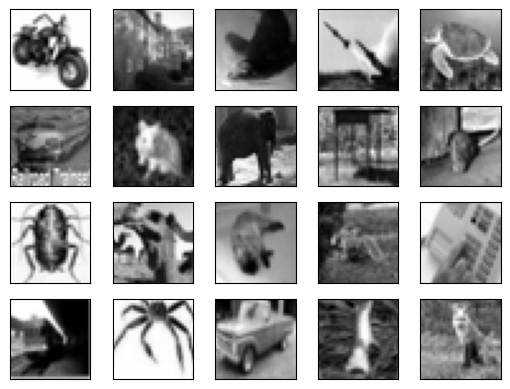

(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)
(32, 32, 1)


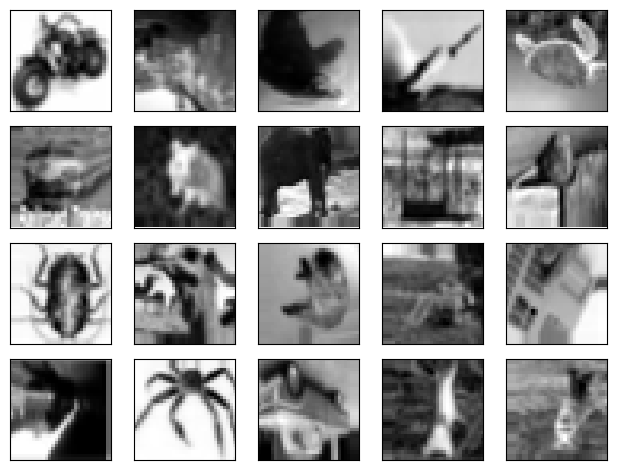

In [9]:
def task1():
    fig, axs = plt.subplots(4, 5)
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        print(x_train[i].shape)
        ax.imshow(x_train[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


task1()

data_augmenter = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, vertical_flip=True,
                                                          width_shift_range=0.1, height_shift_range=0.1,
                                                          validation_split=0.1)


def task_e_exploration():
    augmented_images = []
    num_images_to_augment = 20  # You can change this number based on your requirements

    # Applying augmentation to a subset of images
    for i in range(num_images_to_augment):
        augmented_img = data_augmenter.random_transform(x_train[i])
        print(augmented_img.shape)
        augmented_images.append(augmented_img)

    # Displaying the original and augmented images
    fig, axs = plt.subplots(4, 5)
    axs = axs.flatten()
    
    for i, ax in enumerate(axs):
        ax.imshow(augmented_images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

task_e_exploration()


In [10]:
def C7():
    global y_pred
    h0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3))(input_img)
    h0 = tf.keras.layers.MaxPool2D((2,2))(h0)

    h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(h0)
    h1 = tf.keras.layers.MaxPool2D((2,2))(h1)

    h2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(h1)
    h2 = tf.keras.layers.MaxPool2D((2,2))(h2)

    fh1 = tf.keras.layers.Flatten()(h2)
    fh2 = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh1)
    fh2 = tf.keras.layers.Dropout(0.1)(fh2)
    fh3 = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh2)
    fh3 = tf.keras.layers.Dropout(0.1)(fh3)
    y_pred = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(fh3)

In [12]:
#no batch norm - data augmentation - same as C7 Actually - the idea is just to test it for data augmentation

def E1():
    global y_pred
    h0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3))(input_img)
    h0 = tf.keras.layers.MaxPool2D((2,2))(h0)

    h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(h0)
    h1 = tf.keras.layers.MaxPool2D((2,2))(h1)

    h2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(h1)
    h2 = tf.keras.layers.MaxPool2D((2,2))(h2)

    fh1 = tf.keras.layers.Flatten()(h2)
    fh2 = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh1)
    fh2 = tf.keras.layers.Dropout(0.1)(fh2)
    fh3 = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh2)
    fh3 = tf.keras.layers.Dropout(0.1)(fh3)
    y_pred = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(fh3)




In [13]:
def E2():
    global y_pred
    h0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3))(input_img)
    h0 = tf.keras.layers.BatchNormalization()(h0)
    h0 = tf.keras.layers.MaxPool2D((2,2))(h0)

    h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(h0)
    h1 = tf.keras.layers.BatchNormalization()(h1)
    h1 = tf.keras.layers.MaxPool2D((2,2))(h1)

    h2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(h1)
    h2 = tf.keras.layers.BatchNormalization()(h2)
    h2 = tf.keras.layers.MaxPool2D((2,2))(h2)

    fh1 = tf.keras.layers.Flatten()(h2)
    fh2 = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh1)
    fh2 = tf.keras.layers.BatchNormalization()(fh2)
    fh2 = tf.keras.layers.Dropout(0.1)(fh2)
    fh3 = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh2)
    fh3 = tf.keras.layers.BatchNormalization()(fh3)
    fh3 = tf.keras.layers.Dropout(0.1)(fh3)
    y_pred = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(fh3)

#batch norm on all layers

In [14]:
def E3():
    global y_pred
    h0 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3))(input_img)
    h0 = tf.keras.layers.MaxPool2D((2,2))(h0)

    h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same')(h0)
    h1 = tf.keras.layers.MaxPool2D((2,2))(h1)

    h2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(h1)

    h2 = tf.keras.layers.MaxPool2D((2,2))(h2)

    fh1 = tf.keras.layers.Flatten()(h2)
    fh2 = tf.keras.layers.Dense(units=256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh1)
    fh2 = tf.keras.layers.BatchNormalization()(fh2)
    fh2 = tf.keras.layers.Dropout(0.1)(fh2)
    fh3 = tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(fh2)
    fh3 = tf.keras.layers.BatchNormalization()(fh3)
    fh3 = tf.keras.layers.Dropout(0.1)(fh3)
    y_pred = tf.keras.layers.Dense(units=N_CLASSES, activation='softmax')(fh3)

#batch norm on dense layers only

In [52]:
import os

data_augmenter = tf.keras.preprocessing.image.ImageDataGenerator( rotation_range=25, horizontal_flip=True,
                                                          width_shift_range=0.1, height_shift_range=0.1,
                                                          validation_split=0.2, fill_mode='reflect')

# model.summary()
sampler = tf.keras.preprocessing.image.ImageDataGenerator().flow(x_train, y_train, batch_size=BATCH_SIZE)
sampler_augmented = data_augmenter.flow(x_train, y_train, batch_size=BATCH_SIZE)

def train_and_evaluate_model(y_pred, sampler, model_name, retrain=False, perturbation=False):
    model_save_path = f"{model_name}_model.h5"
    history_csv_path = f'{model_name}_training_history.csv'
    evaluation_csv_path = f'{model_name}_evaluation_results.csv'
    perturbation_csv_path = f'{model_name}_perturbed_results.csv'

    if not retrain and os.path.exists(model_save_path):
        # Load the existing model
        model = tf.keras.models.load_model(model_save_path)
        print(f"Loaded pre-trained model '{model_name}'.")

    else:
        model = tf.keras.Model(input_img, y_pred)
        print(model_name)

        optimizer = tf.keras.optimizers.Adam()

        model.compile(optimizer=optimizer, loss=LOSS, metrics=METRICS)
        history = model.fit(sampler, epochs=EPOCHS, steps_per_epoch=TRAIN_SIZE // BATCH_SIZE, callbacks=CALLBACKS, validation_data=(x_val, y_val))
        
        model.save(model_save_path)


    test_loss, test_acc = model.evaluate(x_val, y_val)
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_csv_path, index=False)

    evaluation_df = pd.DataFrame({'Test Loss': [test_loss], 'Test Accuracy': [test_acc]})
    evaluation_df.to_csv(evaluation_csv_path, index=False)

    if perturbation:
        perturbation_loss, perturbation_acc = model.evaluate(x_perturb, y_perturb)
        perturbation_df = pd.DataFrame({'Perturbation Loss': [perturbation_loss], 'Perturbation Accuracy': [perturbation_acc]})
        perturbation_df.to_csv(perturbation_csv_path, index=False)

    

    return model



In [53]:
E1()
model_name = 'E1-augmented'
train_and_evaluate_model(y_pred, sampler_augmented, model_name, retrain=True, perturbation=True)

E1-augmented
Epoch 1/20
1250/1250 [==============================] - 59s 47ms/step - loss: 6.4692 - accuracy: 0.0777 - val_loss: 4.0504 - val_accuracy: 0.1300 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 58s 47ms/step - loss: 3.3791 - accuracy: 0.1634 - val_loss: 2.9057 - val_accuracy: 0.2310 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 135s 108ms/step - loss: 2.8947 - accuracy: 0.2167 - val_loss: 2.6736 - val_accuracy: 0.2634 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 101s 81ms/step - loss: 2.7786 - accuracy: 0.2285 - val_loss: 2.5928 - val_accuracy: 0.2825 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 71s 56ms/step - loss: 2.7347 - accuracy: 0.2395 - val_loss: 2.7759 - val_accuracy: 0.2480 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 94s 75ms/step - loss: 2.7197 - accuracy: 0.2434 - val_loss: 2.5246 - val_accuracy: 0.2942 - lr: 0.0010
Epoch 7/20
1250/1250 [========

In [ ]:
E2()
model_name = 'E2'
train_and_evaluate_model(y_pred, sampler, model_name, retrain=False, perturbation=True)

E2
Epoch 1/20
1250/1250 [==============================] - 109s 86ms/step - loss: 4.1049 - accuracy: 0.2104 - val_loss: 3.0142 - val_accuracy: 0.2366 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 104s 83ms/step - loss: 2.7705 - accuracy: 0.2876 - val_loss: 2.8518 - val_accuracy: 0.2537 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 106s 84ms/step - loss: 2.6130 - accuracy: 0.3158 - val_loss: 2.8288 - val_accuracy: 0.2735 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 108s 86ms/step - loss: 2.5156 - accuracy: 0.3404 - val_loss: 2.7613 - val_accuracy: 0.2883 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 92s 74ms/step - loss: 2.4556 - accuracy: 0.3571 - val_loss: 3.0763 - val_accuracy: 0.2174 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 92s 73ms/step - loss: 2.3858 - accuracy: 0.3756 - val_loss: 2.5011 - val_accuracy: 0.3379 - lr: 0.0010
Epoch 7/20
1250/1250 [=================

c:\Users\vdako\anaconda3\envs\sam-model-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 9s 27ms/step - loss: 2.4411 - accuracy: 0.3725


In [ ]:
E2()
model_name = 'E2-augmented'
train_and_evaluate_model(y_pred, sampler_augmented, model_name, retrain=True perturbation=True)

E2-augmented
Epoch 1/20
1250/1250 [==============================] - 137s 108ms/step - loss: 4.1310 - accuracy: 0.1621 - val_loss: 3.1019 - val_accuracy: 0.1856 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 127s 101ms/step - loss: 2.9314 - accuracy: 0.2143 - val_loss: 2.9621 - val_accuracy: 0.2217 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 137s 110ms/step - loss: 2.8123 - accuracy: 0.2334 - val_loss: 4.1461 - val_accuracy: 0.1217 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 107s 85ms/step - loss: 2.7547 - accuracy: 0.2451 - val_loss: 2.9984 - val_accuracy: 0.1914 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 6s 21ms/step - loss: 2.9621 - accuracy: 0.2217


c:\Users\vdako\anaconda3\envs\sam-model-env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 7s 23ms/step - loss: 3.0292 - accuracy: 0.1940


In [ ]:
E3()
model_name = 'E3'
train_and_evaluate_model(y_pred, sampler, model_name, retrain=False, perturbation=True)

E3
Epoch 1/20
1250/1250 [==============================] - 81s 64ms/step - loss: 4.1639 - accuracy: 0.1364 - val_loss: 7.4223 - val_accuracy: 0.0818 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 81s 64ms/step - loss: 3.3468 - accuracy: 0.1459 - val_loss: 3.6996 - val_accuracy: 0.0946 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 74s 59ms/step - loss: 3.5181 - accuracy: 0.1479 - val_loss: 4.3921 - val_accuracy: 0.0642 - lr: 0.0010
Epoch 4/20
1250/1250 [==============================] - 76s 61ms/step - loss: 3.2828 - accuracy: 0.1965 - val_loss: 3.9052 - val_accuracy: 0.1166 - lr: 0.0010
Epoch 5/20
1250/1250 [==============================] - 75s 60ms/step - loss: 3.2604 - accuracy: 0.1428 - val_loss: 3.6510 - val_accuracy: 0.0898 - lr: 0.0010
Epoch 6/20
1250/1250 [==============================] - 88s 70ms/step - loss: 3.1610 - accuracy: 0.1647 - val_loss: 3.4255 - val_accuracy: 0.1326 - lr: 0.0010
Epoch 7/20
1250/1250 [=====================

In [ ]:
E3()
model_name = 'E3-augmented'
train_and_evaluate_model(y_pred, sampler_augmented, model_name, retrain=True, perturbation=True)

E3-augmented
Epoch 1/20
1250/1250 [==============================] - 84s 66ms/step - loss: 4.0959 - accuracy: 0.1033 - val_loss: 3.4429 - val_accuracy: 0.0786 - lr: 0.0010
Epoch 2/20
1250/1250 [==============================] - 87s 70ms/step - loss: 3.3739 - accuracy: 0.1263 - val_loss: 9.9775 - val_accuracy: 0.0517 - lr: 0.0010
Epoch 3/20
1250/1250 [==============================] - 88s 70ms/step - loss: 3.5123 - accuracy: 0.1183 - val_loss: 3.5434 - val_accuracy: 0.0855 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 4s 14ms/step - loss: 3.4491 - accuracy: 0.0765


In [93]:
def plot_training_validation_accuracy(model_name):
    df = pd.read_csv(f'{model_name}_training_history.csv')

    # Get training and validation accuracy
    train_acc = df['accuracy']
    val_acc = df['val_accuracy']
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Save the plot as a PNG file
    plt.savefig(f'plots/{model_name}_training_history.png')
    return 

In [ ]:
model_names = ['M1', 'M2', 'M3', 'M4', 'M5', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
for a in model_names:
    plot_training_validation_accuracy(a)

In [38]:
from tensorflow.keras.utils import plot_model
import visualkeras
M5()
model_name = 'M5'
model = tf.keras.Model(input_img, y_pred)
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss=LOSS, metrics=METRICS)


visualkeras.layered_view(model).save(f'architecture_images/{model_name}.png')
# Plot the model architecture to a file (can be PNG, PDF, etc.)
